In [ ]:
#@title
from IPython.display import Image
Image(url='https://i.imgur.com/DeB62Nl.png', width=500)

* [Kaggle Competition Page](https://www.kaggle.com/competitions/leeds-sciml-sea-ice-segmentation)
* [Weights & Biases SciML Leeds team](https://wandb.ai/sciml-leeds)

In [ ]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/U4amljFGkiw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>')

# 🚀 Installing and importing

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
import glob
import os
from tqdm import tqdm
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split

The `patch_paths` variables are arrays containing the names of the patch files.
Each patch patch has a corresponding SAR image, multispectral image, and label. (Except we've not given you the labels for the test patch paths).


In [ ]:
DATA_DIR = 'sciml'
train_patch_paths = np.array([os.path.basename(i[:-9]) for i in glob.glob(f'{DATA_DIR}/train/*_sar.tiff')])
test_patch_paths = np.array([os.path.basename(i[:-9]) for i in glob.glob(f'{DATA_DIR}/test/*_sar.tiff')])

#display patch paths
train_patch_paths

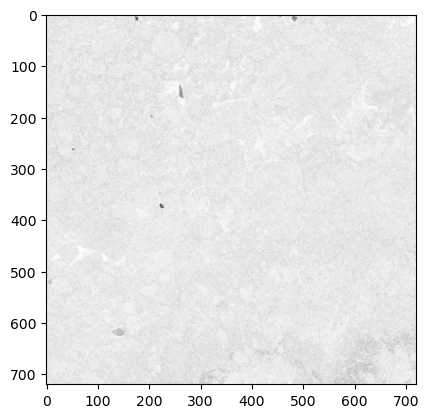

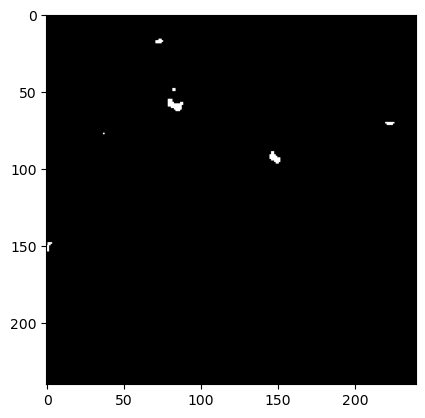

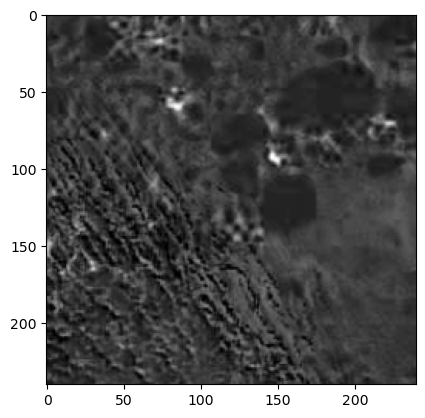

In [92]:
import matplotlib.pyplot as plt
plt.imshow(tifffile.imread(DATA_DIR+'/train/'+train_patch_paths[1240]+'_sar.tiff'), cmap='Greys')
plt.show()
plt.imshow(tifffile.imread(DATA_DIR+'/train/'+train_patch_paths[1240]+'_ref.tiff'), cmap='Greys')
plt.show()
img = tifffile.imread(DATA_DIR+'/train/'+train_patch_paths[1240]+'_vis.tiff')
plt.imshow(img[:,:,0], cmap = 'Greys')
plt.show()

In [102]:
sar = tifffile.imread(DATA_DIR+'/train/'+train_patch_paths[0]+'_sar.tiff')
ms = tifffile.imread(DATA_DIR+'/train/'+train_patch_paths[0]+'_vis.tiff')
lab = tifffile.imread(DATA_DIR+'/train/'+train_patch_paths[0]+'_ref.tiff')

if len(ms.shape) == 3:
    ms = ms.transpose((2, 0, 1))  # Transpose to match PyTorch tensor shape (C, H, W)
    
ms = torch.from_numpy(ms).float()
sar = torch.from_numpy(sar).float()
lab = torch.from_numpy(lab).float()

sar = sar.expand(1,-1,-1)
lab = lab.expand(1,-1,-1)


resize = transforms.Resize((240,240))
sar = resize(sar)

print(ms.shape)
print(sar.shape)
print(lab.shape)

concat = torch.cat((ms, sar, lab), dim=0)
print(concat.shape)

# Define translational Transforms while all concat
trnsfrms = transforms.Compose([
    transforms.RandomResizedCrop(size=240, scale=(0.9,1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.Resize(1024)
])

concat = trnsfrms(concat)

# Get labels back
ms, sar, lab = concat.split((3, 1, 1), dim=0)
print(ms.shape)
print(sar.shape)
print(lab.shape)

torch.Size([3, 240, 240])
torch.Size([1, 240, 240])
torch.Size([1, 240, 240])
torch.Size([5, 240, 240])
torch.Size([3, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])


In [ ]:
# Define translational Transforms while all concat
trnsfrms = transforms.Compose([
    transforms.RandomResizedCrop(size=240, scale=(0.9,1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.Resize(1024) #resize
])

In [112]:
def norm(x, mean, sd):
    x = ((x-mean)/sd)
    x = (x-torch.min(x))/(torch.max(x)-torch.min(x))
    return x

In [124]:
def data_augment(sar, ms, label=None):
    
    # normalise/standardise
    sar = norm(sar,-0.801564234287415,0.16891951952490908)
    ms[0,:,:] = norm(ms[0,:,:],0.3556416964232872,0.5520505638405484)
    ms[1,:,:] = norm(ms[1,:,:],-0.2089460941649551,0.6538063835970725)
    ms[2,:,:] = norm(ms[2,:,:],-0.2977986399965673,0.6143507026534764)
    
    # expand
    sar = sar.expand(1,-1,-1)
    
    # Test Data (no label)
    if label == None:
        resize = transforms.Resize((1024, 1024))
        sar = resize(sar)
        ms = resize(ms)
        
        return sar, ms
    
    # Train data (label)
    else:
        # expand label
        label = label.expand(1,-1,-1)

        # resize and concat
        resize = transforms.Resize((240,240))
        sar = resize(sar)
        concat = torch.cat((sar, ms, label), dim=0)
        concat = trnsfrms(concat)

        # Get labels back
        return concat.split((1, 3, 1), dim=0)

In [125]:
# Custom dataset class
class IceSegmentationDataset(Dataset):
    def __init__(self, patch_paths, data_dir, split='train'):
        self.patch_paths = patch_paths
        self.data_dir = data_dir
        self.split = split

    def __len__(self):
        return len(self.patch_paths)

    def __getitem__(self, index):
        patch_path = self.patch_paths[index]
        sar_path = os.path.join(self.data_dir, self.split, patch_path + '_sar.tiff')
        ms_path = os.path.join(self.data_dir, self.split, patch_path + '_vis.tiff')
        
        sar_arr = self.load_img(sar_path)
        ms_arr = self.load_img(ms_path)
        
        # Test Data
        if self.split == 'test':
            sar_arr, ms_arr = data_augment(sar_arr, ms_arr)
            return (sar_arr, ms_arr) 
        
        # Train Data
        else:
            label_path = os.path.join(self.data_dir, self.split, patch_path + '_ref.tiff')
            label_arr = self.load_img(label_path)
            sar_arr, ms_arr, label_arr = data_augment(sar_arr, ms_arr, label = label_arr)
            return (sar_arr, ms_arr, label_arr)

    def load_img(self, path):
        img = tifffile.imread(path)
        if len(img.shape) == 3:
            img = img.transpose((2, 0, 1))  # Transpose to match PyTorch tensor shape (C, H, W)
        return torch.from_numpy(img).float()

In [126]:
# Create data loaders
batch_size = 32
train_patch_paths, val_patch_paths = train_test_split(train_patch_paths, test_size=0.2, random_state=42)
train_dataset = IceSegmentationDataset(train_patch_paths, DATA_DIR)
val_dataset = IceSegmentationDataset(val_patch_paths, DATA_DIR)
test_dataset = IceSegmentationDataset(test_patch_paths, DATA_DIR, split='test')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [131]:
train_dataset.__getitem__(0)[2].shape

torch.Size([1, 1024, 1024])

The U-Net model architecture is a convolutional neural network that consists of an encoder and a decoder.
The encoder extracts features from the input images, while the decoder upsamples the features to generate the final segmentation map.

The model is compiled with the Adam optimiser and binary cross-entropy loss.
During training, the validation data is used to monitor the performance of the model and early stopping is applied to prevent overfitting.

The training progress can be logged using the wandb library, which allows tracking and visualisation of metrics in a web interface.

In [ ]:
# Define the U-Net model architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.bridge = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.output = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        )

    def forward(self, input_sar, input_ms):
        concat = torch.cat((input_sar, input_ms), dim=1)
        enc1 = self.encoder(concat)
        bridge = self.bridge(enc1)
        dec1 = self.decoder(bridge)
        output = self.output(dec1)
        return output

In [ ]:
# Initialise the model
model = UNet()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Define segment anything model


# ✅ Sign Up

Sign up to a free [Weights & Biases account here](https://wandb.ai/signup)

[Weights and Biases docs](https://docs.wandb.ai/quickstart)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for (input_sar, input_ms), labels in tqdm(train_loader):
        input_sar = input_sar.to(device)
        input_ms = input_ms.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(input_sar, input_ms)
        outputs = outputs[:,:,::4,::4].squeeze()
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * input_sar.size(0)

    epoch_loss = running_loss / len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (input_sar, input_ms), labels in tqdm(val_loader):
            input_sar = input_sar.to(device)
            input_ms = input_ms.to(device)
            labels = labels.to(device)

            outputs = model(input_sar, input_ms)
            outputs = outputs[:,:,::4,::4].squeeze()

            loss = criterion(outputs, labels)

            val_loss += loss.item() * input_sar.size(0)

    val_loss /= len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")




# # Initialize a new W&B run
# wandb_enabled = False

# earlystopper = EarlyStopping(patience=5, verbose=1)
# if wandb_enabled:
#     wandb.init(entity='sciml-leeds', project='sea-ice-segmentation')
#     history = model.fit(train_generator,
#           validation_data=val_generator,
#           epochs=10,
#           use_multiprocessing=True,
#           workers=6,
#           callbacks=[earlystopper, WandbCallback()])
#     wandb.finish()
# else:
#     history = model.fit(train_generator,
#           validation_data=val_generator,
#           epochs=10,
#           use_multiprocessing=True,
#           workers=6,
#           callbacks=[earlystopper])

In [ ]:
# Test
model.eval()
predictions = []
with torch.no_grad():
    for (input_sar, input_ms), _ in test_loader:
        input_sar = input_sar.to(device)
        input_ms = input_ms.to(device)

        outputs = model(input_sar, input_ms)
        predictions.append(outputs.cpu().numpy())

predictions = np.concatenate(predictions)

# Convert predictions to binary mask
predictions = (predictions > 0.5).astype(np.uint8)


In [ ]:
#@title Now plot the results of the training run:

metric_to_plot = 'loss' #@param ['loss', 'accuracy', 'mean_io_u']

ys = history.history[metric_to_plot]
ys_val = history.history['val_'+metric_to_plot]
num_epochs = len(ys)
plt.plot(range(num_epochs), ys, label='train')
plt.plot(range(num_epochs), ys_val, label='val')
plt.legend()
plt.ylabel(metric_to_plot)

Let's dive into the visualization of our sea ice segmentation results using the validation dataset. By running the code snippet provided, we obtain valuable insights into the model's performance and its ability to accurately identify sea ice boundaries.

First, the model makes predictions on the validation dataset using the model.predict() function. The resulting predictions are stored in the variable preds. These predictions represent the segmentation masks, indicating the presence or absence of sea ice in the images.

Next, we extract a single batch of data from the validation generator using next(iter(val_generator)). This batch consists of SAR (Synthetic Aperture Radar) images, multispectral (MS) images, and their corresponding ground truth segmentation masks. These components are unpacked into the variables X_sar_test, X_ms_test, and y_test, respectively.

Now, we proceed to visualize the results. Within a loop, we iterate over the predictions stored in preds. For each prediction, we create a figure with a grid layout of four subplots.

The first subplot, labeled "SAR Image," displays the SAR image from the validation set. SAR imagery provides valuable information about the surface characteristics of sea ice.

The second subplot, labeled "MS Image," showcases the multispectral image captured during the validation process. Multispectral data enables us to analyze sea ice from different spectral perspectives.

Moving on to the third subplot, titled "Segmentation Mask," we observe the model's predicted segmentation mask. The thresholding operation (`preds[i,:,:,0]>threshold`) helps us visualize the predicted sea ice boundaries clearly.

Lastly, the fourth subplot, labeled "Ground Truth," presents the actual ground truth segmentation mask obtained from the validation dataset. This serves as a reference to assess the accuracy of our model's predictions.

By carefully examining these subplots, we can compare the model's predictions against the ground truth and gain insights into the performance and limitations of our sea ice segmentation model.

In [ ]:
#@markdown You need to specify the threshold value, which determines the threshold for classifying pixels as foreground or background. Adjusting this value may affect the performance of the segmentation.

threshold = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}

In [ ]:
preds = model.predict(val_generator,steps=1)

(X_sar_test, X_ms_test), y_test = next(iter(val_generator))

for i in range(preds.shape[0]):
    plt.figure(figsize=(10, 5))
    plt.subplot(141)
    plt.imshow(X_sar_test[i,:,:,:])
    plt.title('SAR Image')
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(X_ms_test[i,:,:,:])
    plt.title('MS Image')
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(preds[i,:,:,0]>threshold)
    plt.title('Segmentation Mask')
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(y_test[i,:,:,0])
    plt.title('Ground Truth')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


* Are there any notable differences between the predicted segmentation mask and the ground truth?
* How does adjusting the threshold value impact the visualisation of the segmentation mask?
* Can you identify any challenging areas where the model struggles to accurately predict sea ice boundaries?
* What potential implications can accurate sea ice segmentation have on environmental research and decision-making processes?

# Generate Submission
Ta-da! 📝🎉 Our model is trained and ready, and it's time to run our predictions on the test set and create the submission file.

A submission file named 'submission.csv' is created to store the predictions.
For each image in the test set, the image ID and run-length encoded pixels are written to the file.

In [ ]:
import pandas as pd

#ref:https://www.kaggle.com/paulorzp/run-length-encode-and-decode.
def rle_encode(mask):
    '''
    mask: numpy array binary mask
    1 - mask
    0 - background
    Returns encoded run length
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Predict on test data
predictions = model.predict(test_generator)

# Generate submission DataFrame
submission_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

for i, patch_path in enumerate(test_patch_paths):
    image_id = os.path.basename(patch_path)
    mask = predictions[i, :, :, 0] > threshold
    encoded_pixels = rle_encode(mask)
    submission_df.loc[i] = [image_id, encoded_pixels]

# Save submission DataFrame to CSV file
submission_df.to_csv('submission.csv', index=False)

In [ ]:
#@title Click to download submission file

from google.colab import files
import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Download csv", width=200, height=200)
output = widgets.Output()

def on_button_clicked(b):
    files.download('submission.csv')

button.on_click(on_button_clicked)
display(button, output)
